Loading BokehJS ...

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


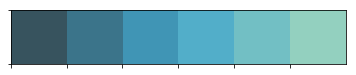

In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-colorblind')
sns.palplot(sns.color_palette("GnBu_d"))

import numpy as np
import scipy.special

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

output_notebook()

import os
import numpy as np
import pandas as pd
import graphviz
from numpy import sort
from pprint import pprint
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

In [2]:
def default_exclusion():
    return ['page_id', 
            'page', 
            'category', 
            'user', 
            'label', 
            'content_token_edit_count_avg', 
            'content_token_vs_stop_words']

def optimized_model_exclusion():
    exclusion = default_exclusion()
#     exclusion.extend(['edit_period_q4'])
    return exclusion

def full_model_exclusion():
    return default_exclusion()

def generalized_model_exclusion():
    exclusion = default_exclusion()
    exclusion.extend(['page_talk_edits',
                        'tenure',
                        'ns1_edit_dist',
                        'ns2_edit_dist',
                        'ns3_edit_dist',
                        'ns4_edit_dist',
                        'ns5_edit_dist',
                        'ns6_edit_dist',
                        'ns7_edit_dist',
                        'ns8_edit_dist',
                        'ns9_edit_dist',
                        'ns10_edit_dist',
                        'ns11_edit_dist',
                        'ns12_edit_dist',
                        'ns13_edit_dist',
                        'ns14_edit_dist',
                        'ns15_edit_dist',
                        'total_edited_pages'])

    
    return exclusion
    
def economical_model_exclusion():
    exclusion = default_exclusion()
    exclusion.extend(['edit_type_a',
                        'edit_type_b',
                        'edit_type_c',
                        'edit_type_d',
                        'edit_type_e',
                        'edit_type_f',
                        'edit_type_g',
                        'edit_type_h',
                        'edit_type_i',
                        'edit_type_j',
                        'edit_type_k',
                        'edit_type_l',
                        'edit_type_m',
                        'edit_type_exists',
                        'avg_persistence',
                        'persistence_exists'])
    return exclusion 

def show_importance(model, X_train):
    print('show_importance')
    names = X_train.columns
    sorted_feature_importances = sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), reverse=True)
    sorted_features = [feature for importance, feature in sorted_feature_importances]
    sorted_importances = [importance for importance, feature in sorted_feature_importances]

    f1, ax1 = plt.subplots(figsize=(15, 12))
    sns.barplot(y=sorted_features, x=sorted_importances, ax=ax1)

    fig = plt.figure()
    fig.set_size_inches(20,20)
    sns.heatmap(X_train.corr())
    
def cross_validation(classifier, x, y, cv):
    print(type(classifier).__name__)
    results = cross_val_score(classifier, x, y, cv=cv)
    
    print(results)
    print('Accuracy: %.3f%%' % (results.mean()))
    print('Precision: %.3f%%' % (cross_val_score(classifier, x, y, scoring='precision', cv=cv).mean())) 
    print('Recall: %.3f%%' % (cross_val_score(classifier, x, y, scoring='recall', cv=cv).mean()))
    print('F1: %.3f%%' % (cross_val_score(classifier, x, y, scoring='f1', cv=cv).mean()))
    print('ROC AUC: %.3f%%' % (cross_val_score(classifier, x, y, scoring='roc_auc', cv=cv).mean()))
    print('\n')
    
def validate_ip(s):
    a = str(s).split('.')
    if len(a) != 4:
        return False
    for x in a:
        if not x.isdigit():
            return False
        i = int(x)
        if i < 0 or i > 255:
            return False
    return True

In [3]:
train = pd.read_csv('data/new_train_data.csv', header=0)
x_train = train.drop(generalized_model_exclusion(), axis=1)
y_train = train.label

In [5]:
train.drop(['edit_type_exists'], axis=1, inplace=True)
edit_types = [col for col in train.columns if str(col).startswith('edit_type')]
print(edit_types)
for edit_type in edit_types:
    train[edit_type].fillna(value=-1, inplace=True)  

['edit_type_a', 'edit_type_b', 'edit_type_c', 'edit_type_d', 'edit_type_e', 'edit_type_f', 'edit_type_g', 'edit_type_h', 'edit_type_i', 'edit_type_j', 'edit_type_k', 'edit_type_l', 'edit_type_m']


In [6]:
xgb=XGBClassifier(objective='binary:logistic')
# classifier.fit(x_train, y_train)

In [7]:
kfold = StratifiedKFold(n_splits=10, random_state=7)
proba = cross_val_predict(estimator=xgb, 
                           X=x_train,
                           y=y_train,
                           cv=kfold, 
                           method='predict_proba')
print(proba)

[[ 0.19306028  0.80693972]
 [ 0.96643448  0.03356549]
 [ 0.10028374  0.89971626]
 ..., 
 [ 0.5564574   0.44354263]
 [ 0.06478137  0.93521863]
 [ 0.07659042  0.92340958]]


In [8]:
positive_proba = pd.Series([p[1] for p in proba])

In [9]:
thresholds = [t/100 for t in range(50, 100, 5)]

pr_cols = ['Threshold', 'Precision', 'Recall', 'Coverage']
pr_rows = []

for threshold in thresholds:
    conf_proba = positive_proba.apply(lambda x: 1 if x > threshold else 0)
    
    coverage = len(conf_proba[conf_proba > threshold])
    precision = precision_score(y_pred=conf_proba, y_true=y_train)
    recall = recall_score(y_pred=conf_proba, y_true=y_train)
    pr_rows.append([threshold, precision, recall, coverage])

df = pd.DataFrame(data=pr_rows, columns=pr_cols)
df.head(10)

,Threshold,Precision,Recall,Coverage
0,0.50,0.726592,0.766798,534
1,0.55,0.745868,0.713439,484
2,0.60,0.752887,0.644269,433
3,0.65,0.769029,0.579051,381
4,0.70,0.785075,0.519763,335
5,0.75,0.825175,0.466403,286
6,0.80,0.843049,0.371542,223
7,0.85,0.867550,0.258893,151
8,0.90,0.915663,0.150198,83
9,0.95,0.894737,0.033597,19


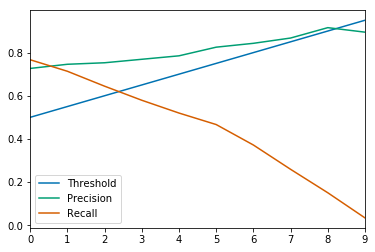

In [10]:
plot_result = df[['Threshold', 'Precision', 'Recall']].plot()

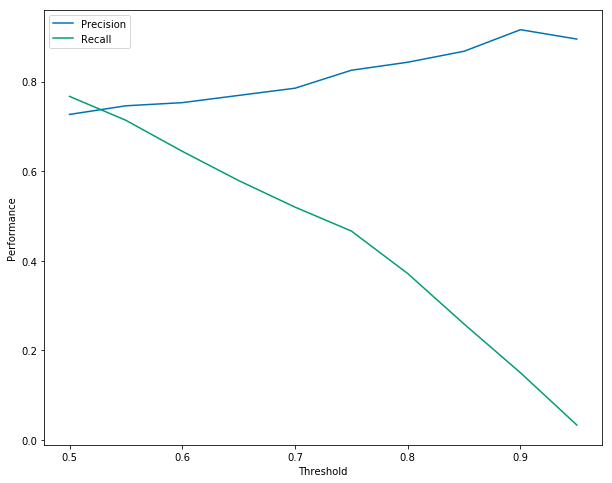

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xlabel('Threshold')
ax.set_ylabel('Performance')

l1 = ax.plot(df['Threshold'], df['Precision'], label='Precision')
l2 = ax.plot(df['Threshold'], df['Recall'], label='Recall')

legend = ax.legend(loc='upper left')

In [12]:
df.to_csv(r'data/new_performance.csv', index=False)